In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cross_validation import cross_val_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (5 * (1 + np.sqrt(5)), 10)

In [64]:
train = pd.read_csv("train.csv")  #Model train data
test = pd.read_csv("test.csv")  #Model test data

# Remaps Sex columns to binary map
genderDic = {'female': 0, 'male': 
             1}
train['Sex'] = train['Sex'].map(genderDic).astype(int)
test['Sex'] = test['Sex'].map(genderDic).astype(int)

pclasses = train.Pclass.value_counts().index.tolist()  #List with all the Pclasses, in this case [1, 2, 3], sort by counts

# Sets the null ages with the mean age of the Pclass and the gender

for sex in genderDic.values():  #0 or 1
    for pclass in pclasses:  #1, 2, 3
        mean = train[(train.Sex == sex) & (train.Pclass == pclass)].Age.dropna().median()
        train.loc[(train.Age.isnull()) & (train.Sex == sex) & (train.Pclass == pclass), 'Age'] = mean
        mean = test[(test.Sex == sex) & (test.Pclass == pclass)].Age.dropna().median()
        test.loc[(test.Age.isnull()) & (test.Sex == sex) & (test.Pclass == pclass), "Age"] = mean


if len(test["Fare"][test["Fare"].isnull()]) > 0:
    median_fare = np.zeros(3)
    for f in pclasses:
        median_fare = test[test.Pclass == f]['Fare'].dropna().median()
        test.loc[(test.Fare.isnull()) & (test.Pclass == f), 'Fare'] = median_fare

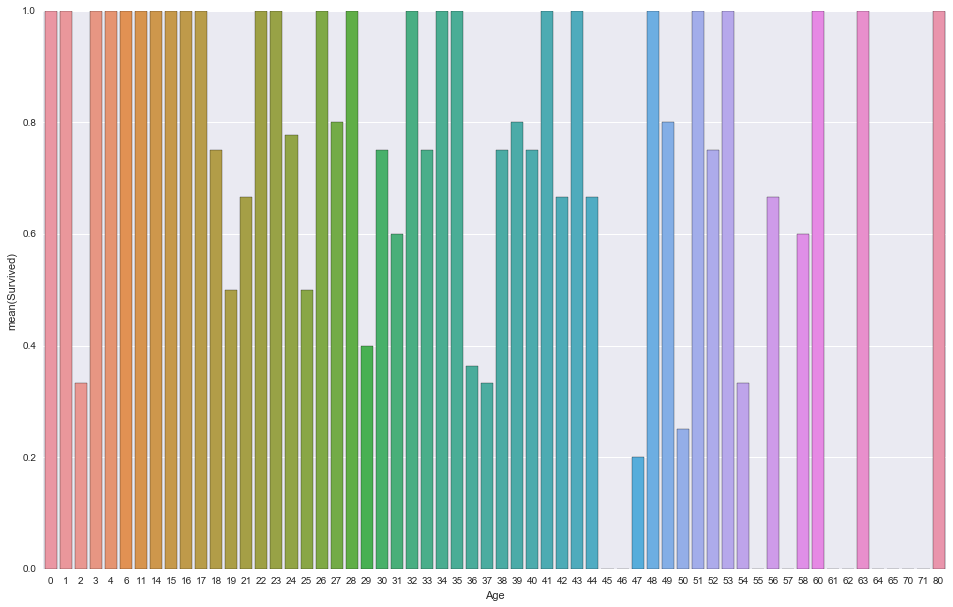

In [3]:
#We plot the mean of survives by age
average_age = train[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
average_age["Age"] = average_age["Age"].astype(int)
sns.barplot(x='Age', y='Survived', data=average_age, ci=None);

In [70]:


# Gets the proportion of the sample size which have Cabin entry not null 
#(created in this particular cell), group by Survivor
# Shows if the Cabin information is relevant for an analysis, 
# or insted is biased by the take of data (in this case, of the survivors vs the manifest of the ship)
# If the result is near 1 is likely that the manifest has no ubication in the ship of the passangers.
cabin = train[["Survived", "Cabin"]].copy()
cabin["CabinIsNull"] = cabin["Cabin"].isnull().astype(int)
cabin[["Survived","CabinIsNull"]].groupby("Survived").mean()

#The result shows that the Cabin information is not meaningfull, biased by the data of the survivors.

,CabinIsNull
Survived,
0,0.876138
1,0.602339


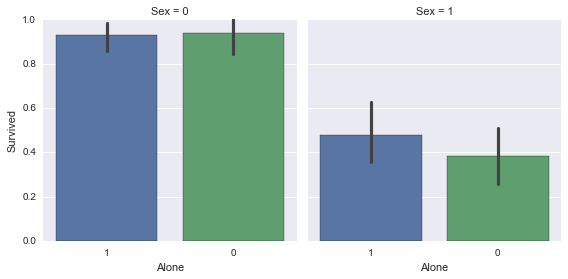

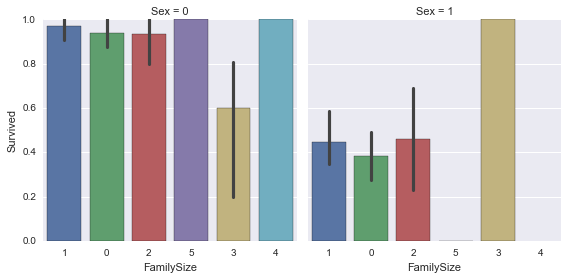

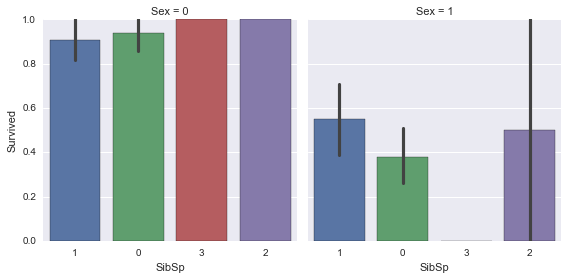

In [4]:
#In this section, we search the chance of survival versus the family size
family = train[["Survived", "SibSp", "Parch", "Sex"]].copy()
family['FamilySize'] = family['SibSp'] + family['Parch']
family["Alone"] = family["FamilySize"].map(lambda x: x != 0).astype(int)


sns.factorplot(x="Alone", y="Survived", col="Sex", data=family, kind="bar")
sns.factorplot(x="FamilySize", y="Survived", col="Sex", data=family, kind="bar", ci=90, n_boot=100)
sns.factorplot(x="SibSp", y="Survived", col="Sex", data=family, kind="bar")

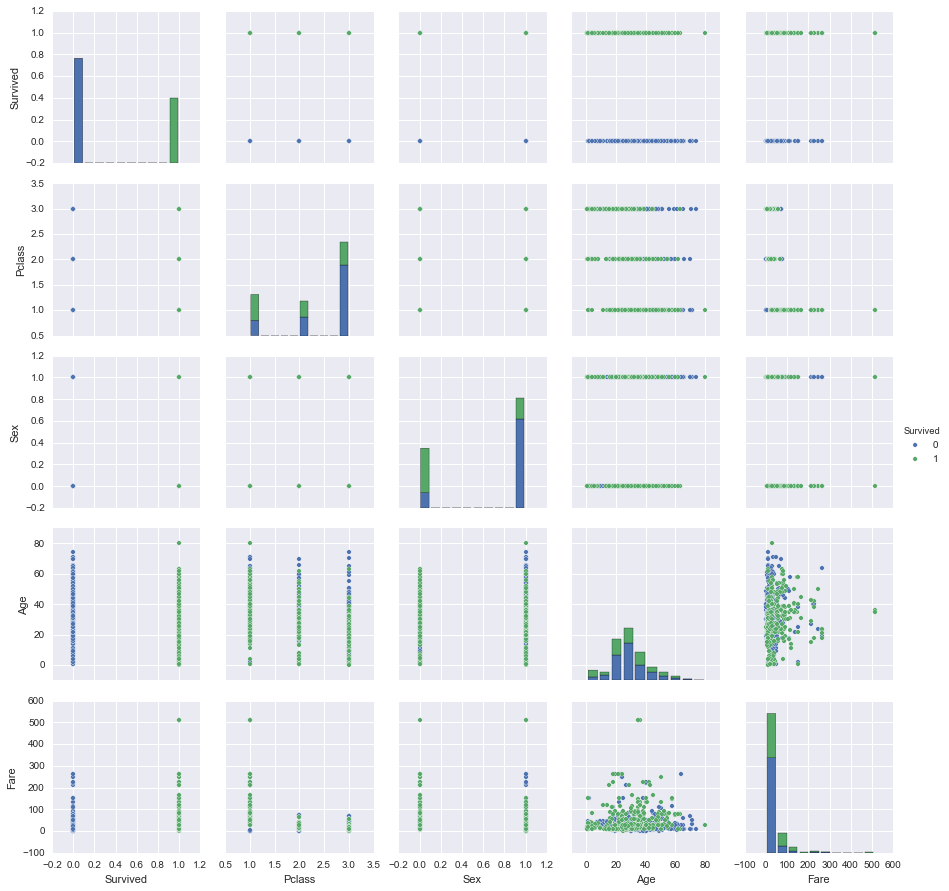

In [65]:
# This is the actual modeling
# In this case the classifier used is a Random Forest, 
# which tries to capture the relations of the data non in parametric ways
# with a number of decision forests (a number that can be changed)

# Features to be droped
dropFeatures = ["Ticket", "Name", "SibSp", "Parch", "Embarked", "Cabin"]

X = train.drop(dropFeatures, axis=1).iloc[:,2:]
sns.pairplot(train.drop(dropFeatures, axis=1).iloc[:,1:],hue="Survived")
Xtest = test.drop(dropFeatures, axis=1).iloc[:,1:]
y = train["Survived"]


0.827 0.124754128559


2

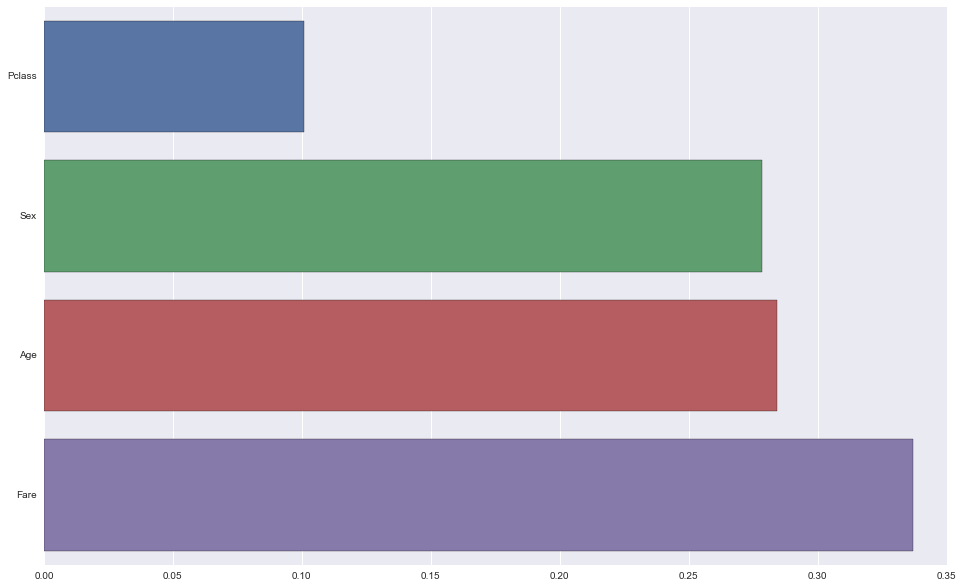

In [72]:
rndF = RandomForestClassifier(max_depth=20, n_estimators=100, max_features="sqrt", n_jobs=-1, random_state = 7463, 
                               oob_score = True)
rndF.fit(X, y)
scores = cross_val_score(rndF, X, y, cv=100, n_jobs=-1, scoring='accuracy')
print(scores.mean(), scores.std())
sns.barplot(rndF.feature_importances_, X.columns.values)
rndF.n_classes_

In [49]:
clf = make_pipeline(StandardScaler(), SVC(C=1.4))
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=30, n_jobs=-1, scoring='accuracy')
print(scores.mean(), scores.std())

0.726984126984 0.148402087729


In [66]:
adaClf = AdaBoostClassifier()
adaClf.fit(X,y)
scores = cross_val_score(adaClf, X, y, cv=100, n_jobs=-1, scoring='accuracy')
print(scores.mean(), scores.std())

0.807027777778 0.134540516065


In [54]:
nbClf = GaussianNB()
nbClf.fit(X,y)
scores = cross_val_score(nbClf, X, y, cv=30, n_jobs=-1, scoring='accuracy')
print(scores.mean(), scores.std())

0.742857142857 0.18053418677


In [69]:
Ypred = rndF.predict(Xtest)
submission = pd.DataFrame({"PassengerId": test["PassengerId"],"Survived": Ypred})
submission.to_csv('submission.csv', index=False)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
